In [ ]:
!gdown #Enter your Kaggle JSON file mounted on Google Colab here

Downloading...
From: https://drive.google.com/uc?id=11IdtjPCK_zig8kxmBF4t9rrMiWmB4a8u
To: /content/kaggle.json
100% 63.0/63.0 [00:00<00:00, 365kB/s]


In [ ]:
!pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d puneet6060/intel-image-classification

 99% 344M/346M [00:14<00:00, 27.3MB/s]
100% 346M/346M [00:14<00:00, 25.6MB/s]


In [ ]:
import zipfile

# Replace 'your_dataset.zip' with the actual name of your zip file
zip_file_path = 'intel-image-classification.zip'
extracted_folder_path = '/content/intel-image-classification'  # You can specify the folder where you want to extract the files

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

print(f'Dataset extracted to {extracted_folder_path}')

Dataset extracted to /content/intel-image-classification


In [ ]:
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

In [ ]:
print(tf.__version__)

2.14.0


# Explore data

In [ ]:
import os
# Walk through the directory and list number of files
print("Train data: ")
for dirpath, dirnames, filenames in os.walk("intel-image-classification/seg_train/seg_train"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
print("Test data: ")
for dirpath, dirnames, filenames in os.walk("intel-image-classification/seg_test/seg_test"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
print("Prediction data: ")
for dirpath, dirnames, filenames in os.walk("intel-image-classification/seg_pred/seg_pred"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

Train data: 
There are 6 directories and 0 images in 'intel-image-classification/seg_train/seg_train'.
There are 0 directories and 2274 images in 'intel-image-classification/seg_train/seg_train/sea'.
There are 0 directories and 2271 images in 'intel-image-classification/seg_train/seg_train/forest'.
There are 0 directories and 2382 images in 'intel-image-classification/seg_train/seg_train/street'.
There are 0 directories and 2512 images in 'intel-image-classification/seg_train/seg_train/mountain'.
There are 0 directories and 2191 images in 'intel-image-classification/seg_train/seg_train/buildings'.
There are 0 directories and 2404 images in 'intel-image-classification/seg_train/seg_train/glacier'.
Test data: 
There are 6 directories and 0 images in 'intel-image-classification/seg_test/seg_test'.
There are 0 directories and 510 images in 'intel-image-classification/seg_test/seg_test/sea'.
There are 0 directories and 474 images in 'intel-image-classification/seg_test/seg_test/forest'.
The

In [ ]:
import random
import matplotlib.pyplot as plt
def view_random_image(target_dir, target_class):
  # We will view image from here
  target_folder = target_dir + target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder+'/'+random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis('off');
  print(f"Image shape {img.shape}")

  return img

Image shape (150, 150, 3)


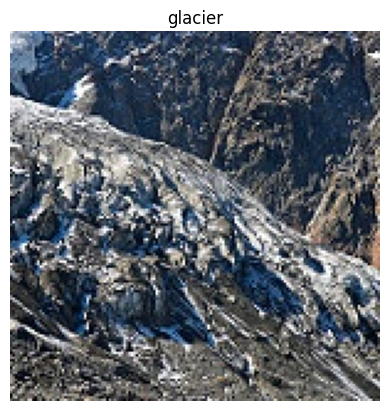

In [ ]:
img = view_random_image(target_dir='intel-image-classification/seg_train/seg_train/',
                  target_class='glacier')

In [ ]:
# Get the class name programmatically
import pathlib
data_dir = pathlib.Path("intel-image-classification/seg_train/seg_train")
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']


Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)


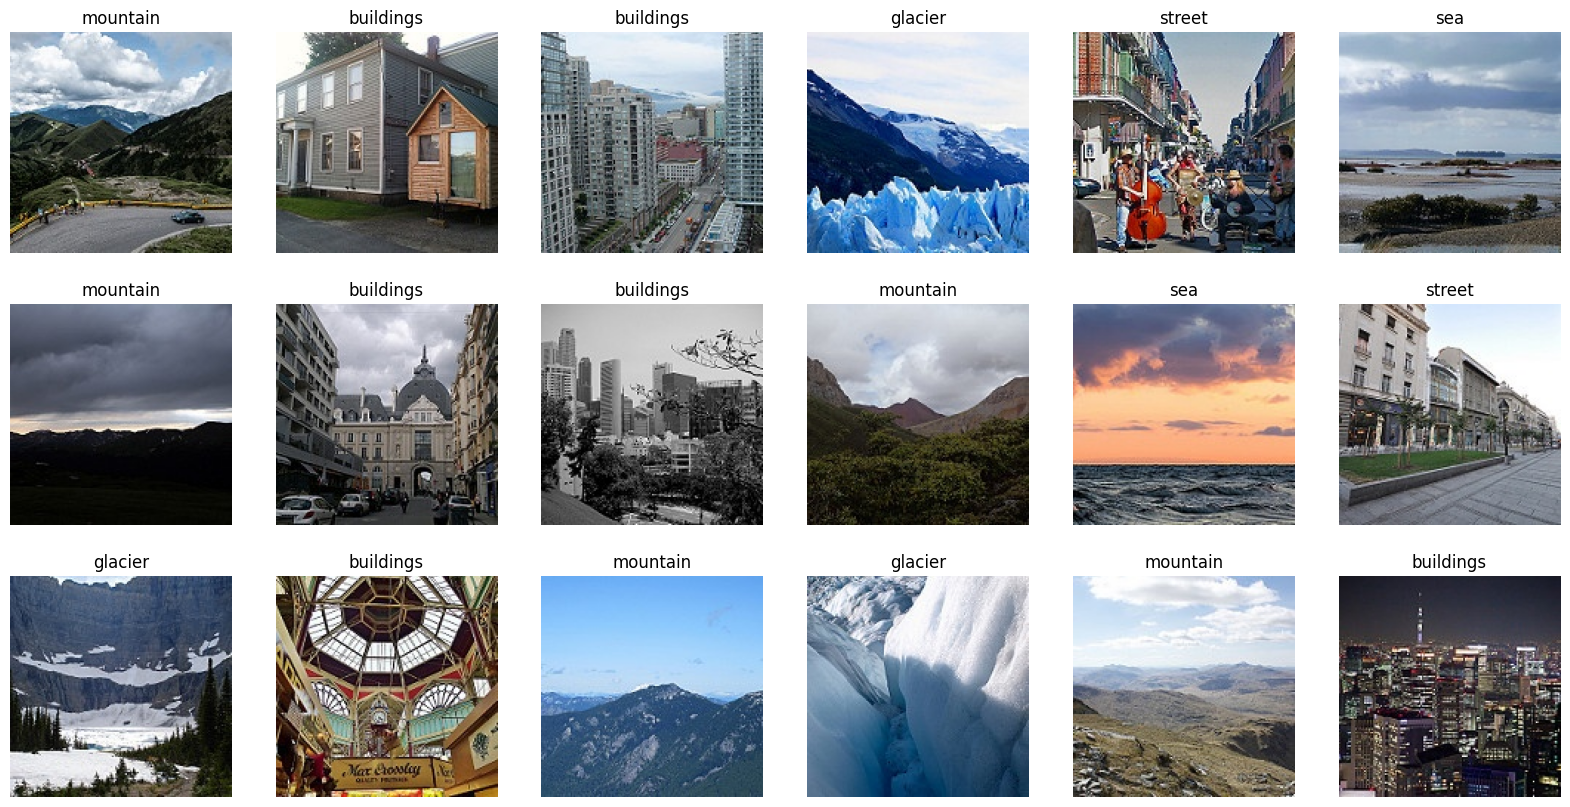

In [ ]:
plt.figure(figsize=(20, 10))
for i in range(18):
  plt.subplot(3, 6, i+1)
  class_name = random.choice(class_names)
  img = view_random_image(target_dir='intel-image-classification/seg_train/seg_train/',
                  target_class=class_name)

# Prepare data for model

In [ ]:
train_dir = "intel-image-classification/seg_train/seg_train/"
test_dir = "intel-image-classification/seg_test/seg_test/"

In [ ]:
# Create augmented data generator instance
train_datagen = ImageDataGenerator(rescale=1/255.,
                                   rotation_range=0.4,
                                   width_shift_range=0.4,
                                   height_shift_range=0.4,
                                   zoom_range=0.4,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1/255.)

# Load data(data, label) from directory and turn them into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(150,150),
                                               batch_size=32,
                                               class_mode='categorical')
test_data = val_datagen.flow_from_directory(test_dir,
                                           target_size=(150,150),
                                           batch_size=32,
                                           class_mode='categorical')

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


# Basic model Building (CNN Classifier)

In [ ]:
model_1 = Sequential([
  Conv2D(16, 3, padding='same', activation='relu', input_shape=(150,150,3)),
  MaxPool2D(),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPool2D(),
  Conv2D(128, 3, padding='same', activation='relu'),
  MaxPool2D(),
  Conv2D(128, 3, padding='same', activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(256, activation='relu'),
  Dense(128, activation='relu'),
  Dense(len(class_names), activation='softmax')
])

model_1.compile(loss="categorical_crossentropy",
              optimizer=Adam(),
              metrics=['accuracy'])
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 37, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 18, 18, 64)        0

In [ ]:
history_1 = model_1.fit(train_data,
                    epochs=10,
                    batch_size=32,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=len(test_data))

Epoch 1/10
439/439 [==============================] - 462s 1s/step - loss: 1.2936 - accuracy: 0.4631 - val_loss: 0.9346 - val_accuracy: 0.6113
Epoch 2/10
439/439 [==============================] - 459s 1s/step - loss: 1.0250 - accuracy: 0.5936 - val_loss: 0.8673 - val_accuracy: 0.6817
Epoch 3/10
439/439 [==============================] - 436s 992ms/step - loss: 0.8700 - accuracy: 0.6699 - val_loss: 0.6099 - val_accuracy: 0.7633
Epoch 4/10
439/439 [==============================] - 437s 996ms/step - loss: 0.7639 - accuracy: 0.7165 - val_loss: 0.5355 - val_accuracy: 0.7953
Epoch 5/10
439/439 [==============================] - 432s 985ms/step - loss: 0.6939 - accuracy: 0.7439 - val_loss: 0.6456 - val_accuracy: 0.7663
Epoch 6/10
439/439 [==============================] - 421s 956ms/step - loss: 0.6573 - accuracy: 0.7585 - val_loss: 0.4629 - val_accuracy: 0.8300
Epoch 7/10
439/439 [==============================] - 422s 959ms/step - loss: 0.6264 - accuracy: 0.7676 - val_loss: 0.4759 - val_a

In [ ]:
model_1.evaluate(test_data)

94/94 [==============================] - 4s 39ms/step - loss: 0.4833 - accuracy: 0.8307


[0.48329630494117737, 0.8306666612625122]

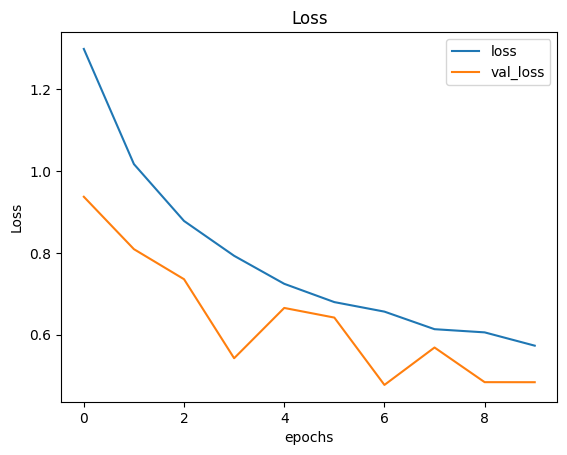

In [ ]:
pd.DataFrame(history_1.history)[['loss','val_loss']].plot()
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('Loss');

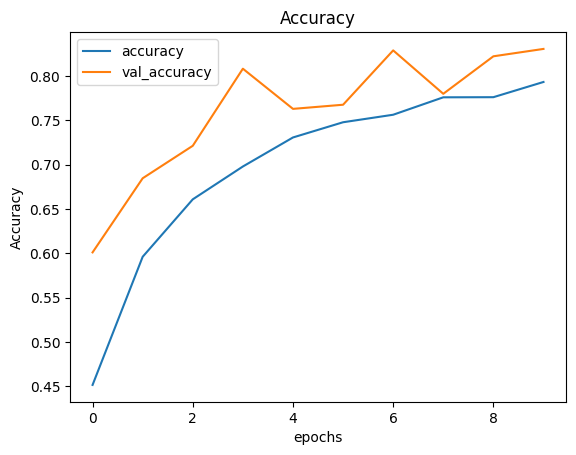

In [ ]:
pd.DataFrame(history_1.history)[['accuracy', 'val_accuracy']].plot()
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy');

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
drive_path = '/content/drive/My Drive/Trained_Models/'

In [ ]:
# model_1.save(drive_path + 'Image_Location_Generator.h5')
model_1.save(drive_path + 'Image_Location_Generator.keras')